In [1]:
import anndata as ad
import os
import pandas as pd
import numpy as np
import scanpy as sc

In [ ]:
adata = sc.read("/gstore/project/crc_recursion_gw/DLD1_Sublib4/DS000016357/Energy_Distance/e_dist_all.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 298497 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    uns: 'DemuxAssignment_hashing_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'energy_distance', 'leiden_colors', 'multivariate_report', 'neighbors', 'perturbation_embeddings', 'perturbations', 'umap'
    obsm: 'X_harmony', 'X_harmony_centered', 'X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'X', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [4]:
adata.uns['energy_distance'].keys()

dict_keys(['perGene_pca_1', 'perGene_pca_10', 'perGene_pca_2', 'perGene_pca_3', 'perGene_pca_4', 'perGene_pca_5', 'perGene_pca_6', 'perGene_pca_7', 'perGene_pca_8', 'perGene_pca_9', 'perGene_pca_centered_1', 'perGene_pca_centered_10', 'perGene_pca_centered_2', 'perGene_pca_centered_3', 'perGene_pca_centered_4', 'perGene_pca_centered_5', 'perGene_pca_centered_6', 'perGene_pca_centered_7', 'perGene_pca_centered_8', 'perGene_pca_centered_9', 'perGene_pca_sphered_1', 'perGene_pca_sphered_10', 'perGene_pca_sphered_2', 'perGene_pca_sphered_3', 'perGene_pca_sphered_4', 'perGene_pca_sphered_5', 'perGene_pca_sphered_6', 'perGene_pca_sphered_7', 'perGene_pca_sphered_8', 'perGene_pca_sphered_9', 'perGene_scVI_1', 'perGene_scVI_10', 'perGene_scVI_2', 'perGene_scVI_3', 'perGene_scVI_4', 'perGene_scVI_5', 'perGene_scVI_6', 'perGene_scVI_7', 'perGene_scVI_8', 'perGene_scVI_9', 'perGene_scVI_centered_1', 'perGene_scVI_centered_10', 'perGene_scVI_centered_2', 'perGene_scVI_centered_3', 'perGene_scVI_ce

In [4]:
def common_genes (embedding_key):
    dfs=[]
    GENEs = []
    for i in range(10):
        STR = "e_dist_500NTCs_"+embedding_key+"_"+str(i+1)
        path  = os.path.join("/gstore/project/crc_recursion_gw/DLD1_Sublib4/DS000016357/Energy_Distance/", f'{STR}.csv')
        df = pd.read_csv(path, index_col=0)
        df = df[df.pvalue<0.05]
        gene = df["gene_symbol"].to_list()
        dfs.append(df)
        GENEs.append(gene)
    com = set.intersection(*[set(list_) for list_ in GENEs])
    return com

## find common genes among 10 permutations in different embedding

In [5]:
com={}
for key in ['pca', 'scVI', 'pca_centered', 'scVI_centered', 'pca_sphered']:
    com[key] = common_genes (key)

In [6]:
com_cnt={}
for key in ['pca', 'scVI', 'pca_centered', 'scVI_centered', 'pca_sphered']:
    com_cnt[key] = len(common_genes (key))

In [7]:
com_cnt

{'pca': 477,
 'scVI': 468,
 'pca_centered': 504,
 'scVI_centered': 439,
 'pca_sphered': 679}

## find common genes among all embedding

In [8]:
com_all = set.intersection(*[set(list_) for k,list_ in com.items()])

In [9]:
len(com_all)

297

## find common genes between scvi_centered and pca_sphered

In [10]:
com_1 = set(com['scVI_centered']).intersection(set(com['pca_sphered']))

In [11]:
len(com_1)

367

In [12]:
A=np.zeros((5,5))

In [13]:
columns = []
for idx, (k, v) in enumerate(com.items()):
    for idx2, (k2,v2) in enumerate(com.items()):
        
        A[idx][idx2] = len(set(v).intersection(set(v2)))
    columns.append(k)

In [14]:
columns

['pca', 'scVI', 'pca_centered', 'scVI_centered', 'pca_sphered']

In [15]:
df = pd.DataFrame(data=A,    
              index=columns,    
              columns=columns)

In [16]:
df

,pca,scVI,pca_centered,scVI_centered,pca_sphered
pca,477.0,327.0,454.0,317.0,420.0
scVI,327.0,468.0,327.0,404.0,379.0
pca_centered,454.0,327.0,504.0,316.0,435.0
scVI_centered,317.0,404.0,316.0,439.0,367.0
pca_sphered,420.0,379.0,435.0,367.0,679.0


{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

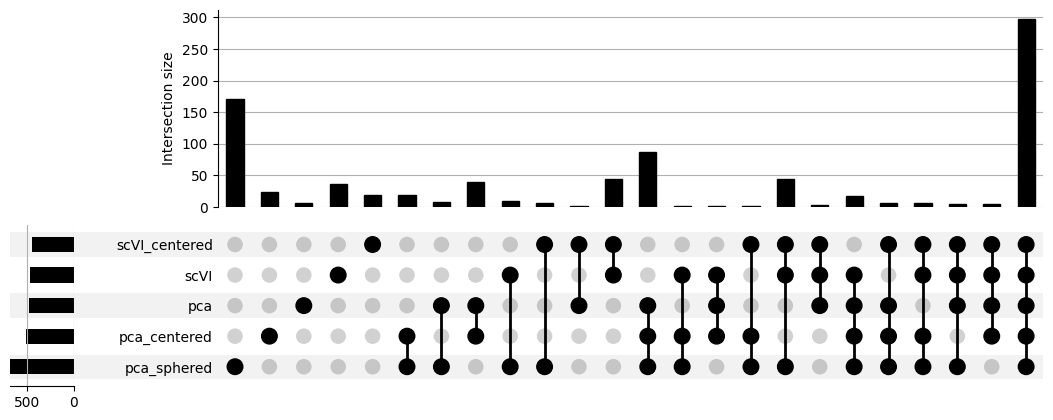

In [17]:
from upsetplot import plot
all_elems = com['pca'].union(com['scVI']).union(com['pca_centered']).union(com['scVI_centered']).union(com['pca_sphered'])
df = pd.DataFrame([[e in com['pca'], e in com['scVI'], e in com['pca_centered'], e in com['scVI_centered'], e in com['pca_sphered']] for e in all_elems], columns = columns)
df_up = df.groupby(columns).size()
plot(df_up, orientation='horizontal')